In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv("train (copy).csv")

In [5]:
df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [8]:
print("Number of Country/Region is", df['Country_Region'].nunique())

print("Countries with Province/State informed are"
      , df[df['Province_State'].isna()==False]['Country_Region'].unique())

Number of Country/Region is 173
Countries with Province/State informed are ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [9]:
df.describe()

,Id,ConfirmedCases,Fatalities
count,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952
std,8487.230117,4541.261768,287.758197
min,1.000000,0.000000,0.000000
25%,7335.750000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000
max,29370.000000,105792.000000,12428.000000


Text(0.5, 0, 'Date')

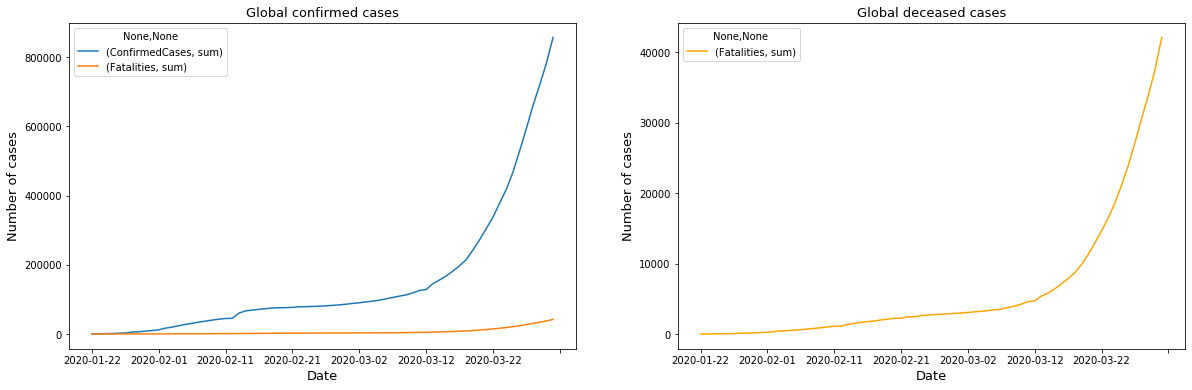

In [10]:
confirmed_dates = df.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_dates = df.groupby(['Date']).agg({'Fatalities':['sum']})
total_dates = confirmed_dates.join(fatalities_dates)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
total_dates.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_dates.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

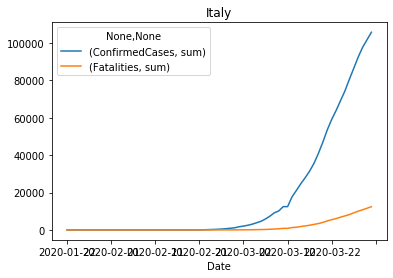

In [12]:
confirmed_total_date_Italy = df[df['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = df[df['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)
total_date_Italy.plot(ax=plt.gca(), title='Italy')

In [13]:
# building datasets for every country
# &(df['Lat'] == df[df['Country/Region'] == c].Lat.iloc[0])
countries_data = {}
for c in df['Country_Region'].unique():
    countries_data[c]=df[(df['Country_Region'] == c)]
    countries_data[c].insert(0, 'New_ID', countries_data[c].Id - countries_data[c].Id.iloc[0])

In [14]:
countries_data['China']

,New_ID,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
3430,0,4901,Anhui,China,2020-01-22,1.0,0.0
3431,1,4902,Anhui,China,2020-01-23,9.0,0.0
3432,2,4903,Anhui,China,2020-01-24,15.0,0.0
3433,3,4904,Anhui,China,2020-01-25,39.0,0.0
3434,4,4905,Anhui,China,2020-01-26,60.0,0.0
...,...,...,...,...,...,...,...
5735,3265,8166,Zhejiang,China,2020-03-27,1247.0,1.0
5736,3266,8167,Zhejiang,China,2020-03-28,1251.0,1.0
5737,3267,8168,Zhejiang,China,2020-03-29,1254.0,1.0
5738,3268,8169,Zhejiang,China,2020-03-30,1255.0,1.0


In [19]:
pd.set_option('mode.chained_assignment', None)
def build_model(c, target, num): # num representes the day

    data = countries_data[c]
    data.New_ID = data.New_ID - data.New_ID.iloc[0]
    X = np.array(data['New_ID']).reshape(-1, 1)
    y = np.array(data[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scores = []

    for i in range(1, 11):
        print("Euation of "+str(i)+" Degree BEGINS")
        poly = PolynomialFeatures(degree=i)
        poly_x = poly.fit_transform(X_train)
        pol_reg = LinearRegression()
        pol_reg.fit(poly_x, y_train)
        print("Euation of "+str(i)+" Degree Ends with acc = "+str(pol_reg.score(poly.fit_transform(X_test), y_test)*100) + "%")
        scores.append(pol_reg.score(poly.fit_transform(X_test), y_test))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.plot(X, y)
    ax1.set_title(c + " confirmed cases", size=13)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date_ID", size=13)
    ax2.plot(range(1, 11), scores, color='orange')
    ax2.set_title("Accuracy vs. Degree", size=13)
    ax2.set_ylabel("Accuracy", size=13)
    ax2.set_xlabel("Degree", size=13)
    
    # finding best degree for each country
    max_ = 0
    max_i = 0
    for index, acc in enumerate(scores):
        if acc > max_:
            max_ = acc
            max_i = index
    print("Best PolynomialDegree is " + str(max_i+1) + " with accuracy " + str(max_*100) + "%")
    max_i += 1
    poly = PolynomialFeatures(degree=max_i)
    poly_x = poly.fit_transform(X_train)
    pol_reg = LinearRegression()
    pol_reg.fit(poly_x, y_train)
    prediction = pol_reg.predict(poly.fit_transform([[num]]))
    return int(prediction)

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 41.84830722397983%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 79.94660552063648%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 96.76891952366478%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.53609955627388%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.56325369616653%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.60102661472884%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.68294618389972%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.73851989740055%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.72392191739358%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.72278060071295%
Best PolynomialDegree is 8 with accuracy 99.73851989740055%


26

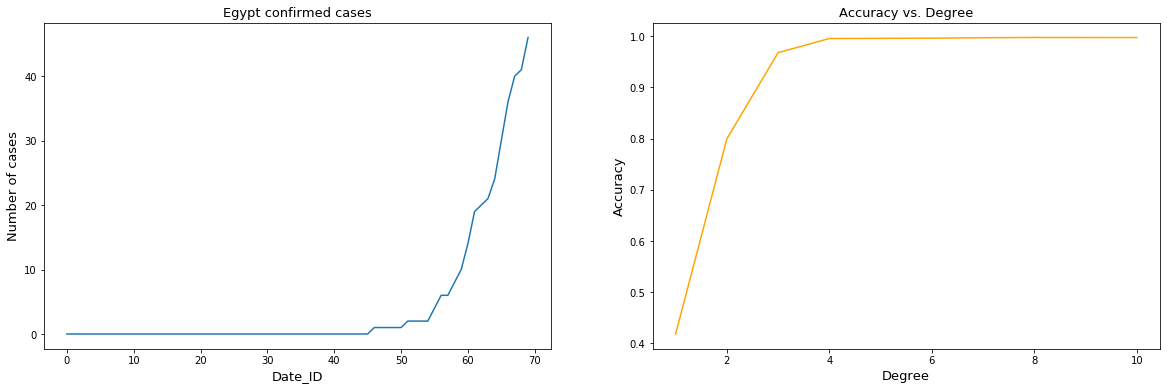

In [20]:
build_model('Egypt', 'Fatalities', 64) # for Egypt

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 61.44188895485942%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 92.44632394307071%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 99.32393980391683%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.35910651894076%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.64656058414992%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.80311717759389%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.80345826056866%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.81089066105655%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.812783272541%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.8130772302951%
Best PolynomialDegree is 10 with accuracy 99.8130772302951%


487

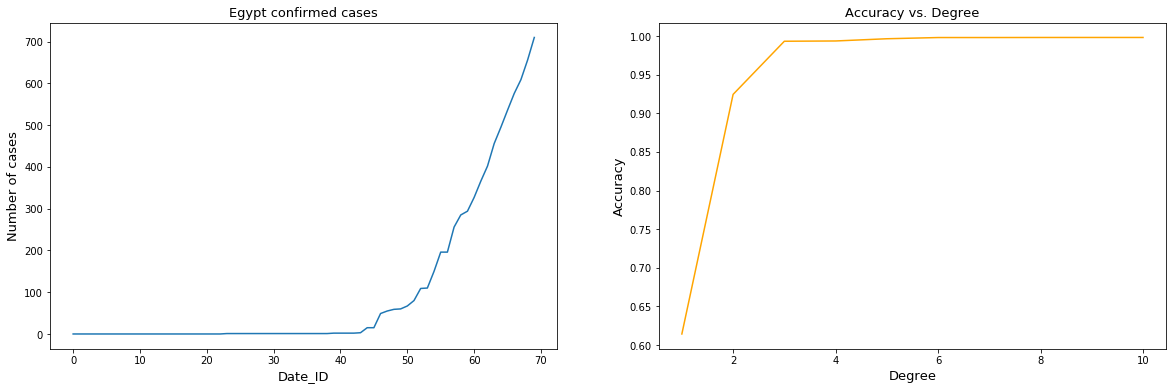

In [21]:
build_model('Egypt', 'ConfirmedCases', 64) # for Egypt

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 59.515781840511%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 93.62638990564493%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 99.15054926783927%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.25395411775078%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.63722840378338%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.91759965169845%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.92777085454956%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.9320025697904%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.94181163170536%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.94262313644995%
Best PolynomialDegree is 10 with accuracy 99.94262313644995%


58099

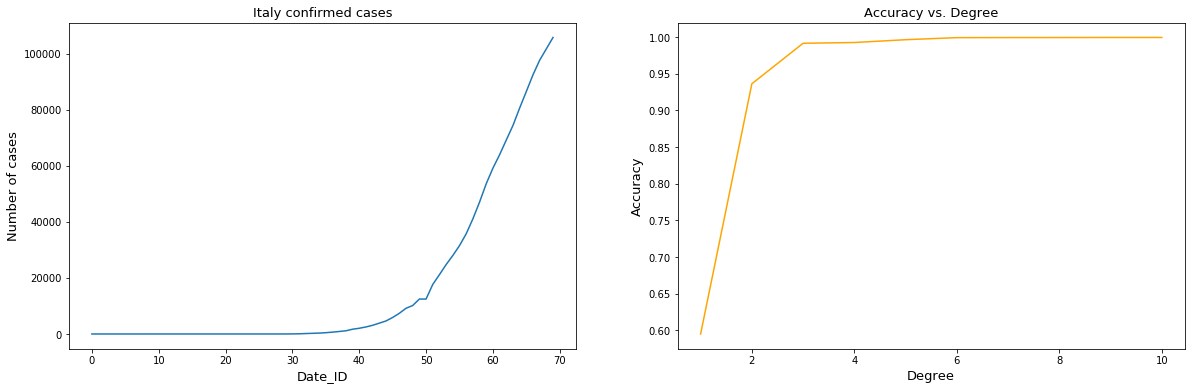

In [23]:
build_model('Italy','ConfirmedCases', 60)

Euation of 1 Degree BEGINS
Euation of 1 Degree Ends with acc = 55.142014788568126%
Euation of 2 Degree BEGINS
Euation of 2 Degree Ends with acc = 88.45642128724567%
Euation of 3 Degree BEGINS
Euation of 3 Degree Ends with acc = 98.99954053520484%
Euation of 4 Degree BEGINS
Euation of 4 Degree Ends with acc = 99.8149509894633%
Euation of 5 Degree BEGINS
Euation of 5 Degree Ends with acc = 99.8581535394625%
Euation of 6 Degree BEGINS
Euation of 6 Degree Ends with acc = 99.94833691838109%
Euation of 7 Degree BEGINS
Euation of 7 Degree Ends with acc = 99.9758948858649%
Euation of 8 Degree BEGINS
Euation of 8 Degree Ends with acc = 99.9759956420117%
Euation of 9 Degree BEGINS
Euation of 9 Degree Ends with acc = 99.97897794566649%
Euation of 10 Degree BEGINS
Euation of 10 Degree Ends with acc = 99.98017926369698%
Best PolynomialDegree is 10 with accuracy 99.98017926369698%


5344

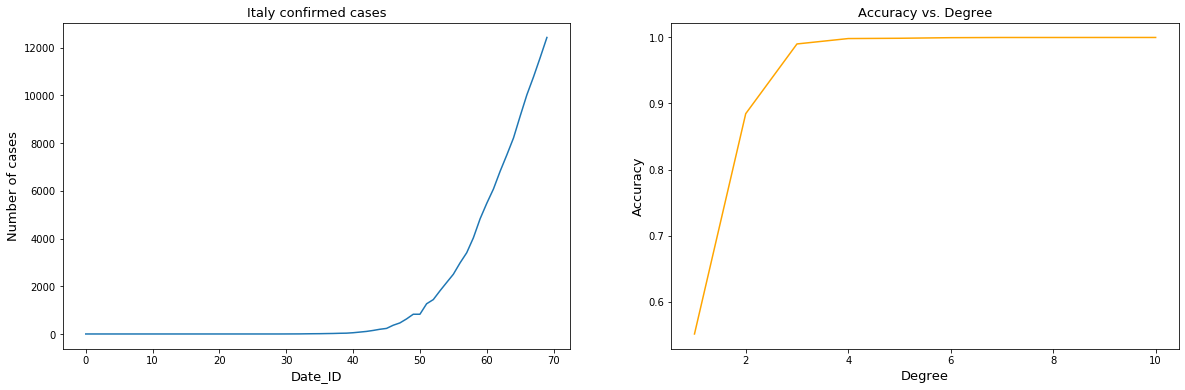

In [22]:
build_model('Italy','Fatalities', 60)

In [24]:
def build_model_reduced(c, target, num): # num representes the day

    data = countries_data[c]
    data.New_ID = data.New_ID - data.New_ID.iloc[0]
    X = np.array(data['New_ID']).reshape(-1, 1)
    y = np.array(data[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scores = []

    for i in range(1, 11):
        poly = PolynomialFeatures(degree=i)
        poly_x = poly.fit_transform(X_train)
        pol_reg = LinearRegression()
        pol_reg.fit(poly_x, y_train)
        scores.append(pol_reg.score(poly.fit_transform(X_test), y_test))
    
    # finding best degree for each country
    max_ = 0
    max_i = 0
    for index, acc in enumerate(scores):
        if acc > max_:
            max_ = acc
            max_i = index
    print("Best PolynomialDegree is " + str(max_i+1) + " with accuracy " + str(max_*100) + "%")
    max_i += 1
    poly = PolynomialFeatures(degree=max_i)
    poly_x = poly.fit_transform(X_train)
    pol_reg = LinearRegression()
    pol_reg.fit(poly_x, y_train)
    prediction = pol_reg.predict(poly.fit_transform([[num]]))
    return int(prediction)


In [25]:
build_model_reduced('Egypt', 'Fatalities', 57)

Best PolynomialDegree is 9 with accuracy 99.5927920189993%


7

In [28]:
# test file reading
dt = pd.read_csv('test (copy).csv')

In [29]:
dt.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23


In [30]:
dt.iloc[15, 2], dt.iloc[0, 3]

('Afghanistan', '2020-03-19')

In [33]:
import csv
counter = 57
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ForecastId", "ConfirmedCases", "Fatalities"])
    conf_arr = []
    death_arr = []
    for i in range(0, 57):
        conf_arr.append(0)
        death_arr.append(0)
    for i in range(1, len(dt)+1):
        print('writing to ' + str(i) + 'th row')

        conf = abs(build_model_reduced(dt.iloc[i, 2], 'ConfirmedCases', counter))
        death = abs(build_model_reduced(dt.iloc[i, 2], 'Fatalities', counter))
        conf_arr.append(conf)
        death_arr.append(death)
        if(conf_arr[-1] < conf_arr[-2]):
            conf_arr[-1] = conf_arr[-2]
        if(death_arr[-1] < death_arr[-2]):
            death_arr[-1] = death_arr[-2]
        print(counter, [i, conf_arr[-1], death_arr[-1]])
        print(counter, [i, conf_arr[-2], death_arr[-2]])
        writer.writerow([i, conf, death])
        
        if counter == 99:
            counter = 57
            conf_arr = []
            death_arr = []
            for i in range(0, 57):
                conf_arr.append(0)
                death_arr.append(0)
        else:
            counter += 1

writing to 1th row
Best PolynomialDegree is 10 with accuracy 91.74187350954334%
Best PolynomialDegree is 10 with accuracy 29.450498824008154%
57 [1, 25, 0]
57 [1, 0, 0]
writing to 2th row
Best PolynomialDegree is 5 with accuracy 99.10464731021864%
Best PolynomialDegree is 1 with accuracy 0%
58 [2, 29, 1]
58 [2, 25, 0]
writing to 3th row
Best PolynomialDegree is 10 with accuracy 98.06437401076121%
Best PolynomialDegree is 10 with accuracy 92.2105924054337%
59 [3, 34, 1]
59 [3, 29, 1]
writing to 4th row
Best PolynomialDegree is 9 with accuracy 98.62444528322033%
Best PolynomialDegree is 10 with accuracy 96.6104115283515%
60 [4, 43, 1]
60 [4, 34, 1]
writing to 5th row
Best PolynomialDegree is 10 with accuracy 98.67838953512292%
Best PolynomialDegree is 1 with accuracy 0%
61 [5, 51, 1]
61 [5, 43, 1]
writing to 6th row
Best PolynomialDegree is 8 with accuracy 93.9306868694438%
Best PolynomialDegree is 5 with accuracy 90.32037164129181%
62 [6, 64, 1]
62 [6, 51, 1]
writing to 7th row
Best Pol

KeyboardInterrupt: 